
# FNC 7.1 — Exercises 4–5 (Python Notebook)

This notebook answers the programming exercises from **FNC 7.1 — From matrix to insight**.

- **Exercise 4**: basic image manipulations on the **`lighthouse.png`** test image.  
- **Exercise 5**: actor–movie bipartite matrix analysis (loading `actors.jld2` and computing requested statistics).

> Tested with Python 3.10+ on a standard scientific stack. The notebook will auto-download the required assets (image & dataset) if not present.


In [1]:

# If you're running locally and miss a dependency, uncomment the next line.
# %pip install numpy scipy matplotlib pillow h5py tqdm

import os, sys, io, urllib.request, shutil, gzip, json, math, textwrap, pathlib, itertools, subprocess, importlib.util
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Optional: h5py & scipy.sparse for Exercise 5
try:
    import h5py
except Exception as e:
    h5py = None
try:
    from scipy import sparse
except Exception as e:
    sparse = None

DATA_DIR = Path("./_fnc_assets")
DATA_DIR.mkdir(exist_ok=True)
print("Asset dir:", DATA_DIR.resolve())


Asset dir: C:\Users\guanyu\Desktop\numerical-analysis-seminar\numerical-analysis-seminar-datahub\solution\code\ch7\_fnc_assets


In [2]:

def download(url: str, dest: Path, desc: str = "") -> Path:
    '''Download a file with a tiny progress bar if not exists.'''
    dest = Path(dest)
    if dest.exists():
        return dest
    print(f"Downloading {desc or url} -> {dest}")
    with urllib.request.urlopen(url) as r, open(dest, "wb") as f:
        total = int(r.headers.get("Content-Length", 0) or 0)
        from tqdm import tqdm
        with tqdm(total=total, unit="B", unit_scale=True) as pbar:
            while True:
                chunk = r.read(1024 * 64)
                if not chunk:
                    break
                f.write(chunk)
                pbar.update(len(chunk))
    return dest



## Exercise 4 — Image operations on `lighthouse.png`

We will:
1. Display the “lighthouse” image **upside-down** (vertical flip).  
2. Display it **mirror-reversed left-to-right** (horizontal flip).  
3. **Crop** a tight region around the black beacon (lantern room) at the top of the lighthouse.


Image size: (768, 512)


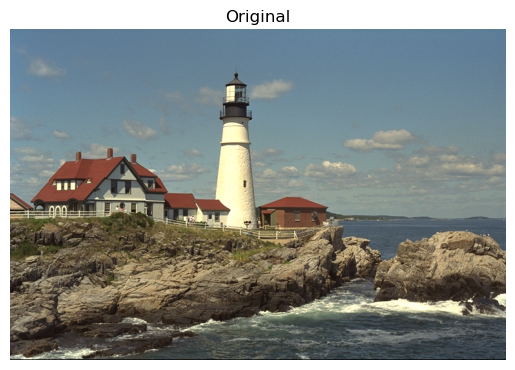

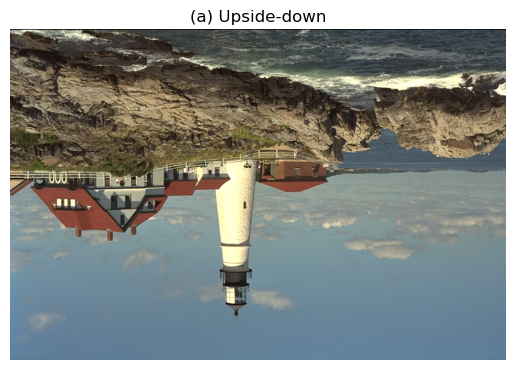

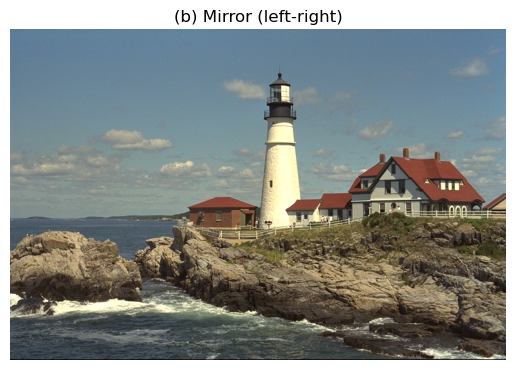

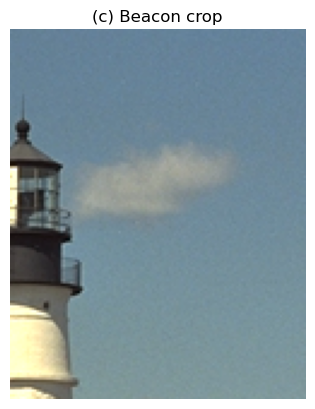

In [3]:

LIGHTHOUSE_URL = "https://raw.githubusercontent.com/JuliaImages/TestImages.jl/images/images/lighthouse.png"
light_path = DATA_DIR / "lighthouse.png"
download(LIGHTHOUSE_URL, light_path, desc="lighthouse.png")

# Load with Pillow
img = Image.open(light_path).convert("RGB")
w, h = img.size
print("Image size:", img.size)

# (a) upside-down (vertical flip)
upsidedown = img.transpose(Image.FLIP_TOP_BOTTOM)

# (b) mirror-reversed left-to-right (horizontal flip)
mirror_lr = img.transpose(Image.FLIP_LEFT_RIGHT)

# (c) crop to isolate the black beacon (lantern room).
# We choose a fractional bounding box tuned for this specific test image.
# Fractions were chosen by visually inspecting the image: the beacon is near top-center.
x0, y0, x1, y1 = 0.45, 0.06, 0.61, 0.36  # (left, top, right, bottom) in fractions of width/height
box = (int(x0*w), int(y0*h), int(x1*w), int(y1*h))
beacon_crop = img.crop(box)

# Show results
for title, im in [
    ("Original", img),
    ("(a) Upside-down", upsidedown),
    ("(b) Mirror (left-right)", mirror_lr),
    ("(c) Beacon crop", beacon_crop),
]:
    plt.figure()
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
    plt.show()



## Exercise 5 — Actor–movie bipartite matrix

Dataset: `actors.jld2` (provided by the book). It stores a binary sparse matrix `A` of shape **(movies × actors)** where

- `A[i, j] = 1` iff **actor j** appeared in **movie i** (else 0).

We need to compute:
- **(a)** the **maximum** number of actors in any one movie (i.e., `max(row-sum(A))`),  
- **(b)** the number of **actors** who appeared in **exactly three** movies (i.e., `count(col-sum(A) == 3)`),  
- **(c)** with `C = Aᵀ A`, the number of **nonzeros** in `C` and the interpretation of `C_ij`.


In [4]:

ACTORS_URL = "https://tobydriscoll.net/fnc-julia/_static/resources/actors.jld2"
actors_path = DATA_DIR / "actors.jld2"
download(ACTORS_URL, actors_path, desc="actors.jld2")

def load_jld2_sparse_csc(path: Path):
    """
    读取 JLD2 保存的 SparseMatrixCSC:
    '/A' 为 Dataset(复合类型, 字段含 object reference) 的情形
    返回: scipy.sparse.csc_matrix
    """
    with h5py.File(path, "r") as h5:

        # --- Case 1: '/A' 是一个 0-d 复合类型 Dataset，字段含对象引用 ---
        if "A" in h5 and isinstance(h5["A"], h5py.Dataset):
            ds = h5["A"]
            names = ds.dtype.names or ()
            want = {"m", "n", "colptr", "rowval", "nzval"}
            if want.issubset(set(names)):
                rec = ds[()]  # 取出 0-d 记录 (numpy.void)
                m = int(rec["m"])
                n = int(rec["n"])

                # 解引用得到实际的数据集，再读成 numpy 数组
                colptr = np.array(h5[rec["colptr"]], dtype=np.int64).ravel()
                rowval = np.array(h5[rec["rowval"]], dtype=np.int64).ravel()
                nzval  = np.array(h5[rec["nzval"]]).ravel()

                # JLD2/Julia 是 1-based 索引；SciPy 需要 0-based
                colptr = colptr - 1
                rowval = rowval - 1

                # 值是二值/整数，统一转成 int8 以省内存
                nzval = (nzval != 0).astype(np.int8)

                A = sparse.csc_matrix((nzval, rowval, colptr), shape=(m, n))
                return A
    return None

try:
    A = load_jld2_sparse_csc(actors_path)
    print("Loaded A (movies × actors):", A.shape, "nnz =", A.nnz, "density ~", A.nnz / (A.shape[0]*A.shape[1]))
except Exception as e:
    print("Primary JLD2 loader failed:", e)
    A = None


Loaded A (movies × actors): (127823, 392400) nnz = 1470404 density ~ 2.93155921211546e-05


In [5]:
A

<127823x392400 sparse matrix of type '<class 'numpy.int8'>'
	with 1470404 stored elements in Compressed Sparse Column format>

In [6]:

# (a) Maximum number of actors in any movie = max row nnz (since binary)
row_counts = np.asarray(A.getnnz(axis=1)).ravel()
max_actors_per_movie = int(row_counts.max())

# (b) Number of actors who appeared in exactly three movies = count where column nnz == 3
col_counts = np.asarray(A.getnnz(axis=0)).ravel()
actors_in_3_movies = int((col_counts == 3).sum())

# (c) C = A^T A; number of nonzeros and interpretation
C = (A.T @ A).tocsr()  # symmetric
nnz_C = int(C.nnz)

print(f"(a) Max actors in any one movie: {max_actors_per_movie}")
print(f"(b) # actors who appeared in exactly three movies: {actors_in_3_movies}")
print(f"(c) nnz(C = A^T A) = {nnz_C}")
print( "    Interpretation: C[i,j] is the number of movies in which actors i and j co-appeared;")
print( "    in particular, C[i,i] equals the number of movies actor i appeared in.")


(a) Max actors in any one movie: 294
(b) # actors who appeared in exactly three movies: 21527
(c) nnz(C = A^T A) = 30459805
    Interpretation: C[i,j] is the number of movies in which actors i and j co-appeared;
    in particular, C[i,i] equals the number of movies actor i appeared in.
